# Big Data Bowl 2026 - Phase 3: Air Play IQ Metrics

## Overview

This notebook combines outputs from Phase 1 (route modeling) and Phase 2 (post-throw convergence) to create intuitive, coach-friendly metrics:

1. **RouteExecIQ**: How well did the WR execute their route (pre-throw)?
2. **ConvergenceIQ_WR**: How efficiently did the WR track the ball (post-throw)?
3. **AirPlayIQ_WR**: Overall WR performance combining both components

**Data Sources**:
- `wr_routes_embeddings.csv` (Phase 1 output)
- `postthrow_predictions.csv` (Phase 2 output)
- `supplementary_data.csv` (original data)

---

## Setup

In [108]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Data

In [109]:
# File paths
data_dir = r"C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl"
routes_path = f"{data_dir}\\wr_routes_embeddings.csv"
predictions_path = f"{data_dir}\\postthrow_predictions_Completed_Pass.csv"
supp_path = f"{data_dir}\\supplementary_data.csv"

print("Loading data...")
df_routes = pd.read_csv(routes_path)
df_predictions = pd.read_csv(predictions_path)
df_supp = pd.read_csv(supp_path)

print(f"\nData loaded!")
print(f"  Routes: {df_routes.shape}")
print(f"  Predictions: {df_predictions.shape}")
print(f"  Supplementary: {df_supp.shape}")

Loading data...

Data loaded!
  Routes: (8202, 26)
  Predictions: (53785, 6)
  Supplementary: (18009, 41)


In [110]:
# Preview data
print("Route embeddings columns:")
print(df_routes.columns.tolist()[:15], "...")

print("\nPredictions columns:")
print(df_predictions.columns.tolist())

print("\nSample route data:")
df_routes.head()

Route embeddings columns:
['game_id', 'play_id', 'nfl_id', 'player_name', 'player_position', 'route_embed_1', 'route_embed_2', 'route_embed_3', 'route_embed_4', 'route_embed_5', 'route_embed_6', 'route_embed_7', 'route_embed_8', 'route_embed_9', 'route_embed_10'] ...

Predictions columns:
['game_id', 'play_id', 'frame_id', 'actual_converge_rate', 'predicted_converge_rate', 'residual']

Sample route data:


,game_id,play_id,nfl_id,player_name,player_position,route_embed_1,route_embed_2,route_embed_3,route_embed_4,route_embed_5,route_embed_6,route_embed_7,route_embed_8,route_embed_9,route_embed_10,route_embed_11,route_embed_12,route_embed_13,route_embed_14,route_embed_15,pass_result,route_label,yards_gained,expected_points_added,route_cluster,pass_result_num
0,2023090700,101,44930,Josh Reynolds,WR,11.773586,11.40,1.97,52.43,14.14,7.90,4.611154,2.936111,5.56,2.975769,2,26,2.5,2.20,0.982620,I,CORNER,0,-2.145443,5,1
1,2023090700,361,38696,Marvin Jones,WR,17.888180,13.54,10.43,34.19,48.33,6.78,3.500980,2.358838,5.71,2.765490,1,51,5.0,10.45,0.955459,C,HITCH,5,-0.862062,3,0
2,2023090700,436,53541,Amon-Ra St. Brown,WR,4.892001,4.21,1.88,33.67,37.80,4.43,2.512000,1.666558,6.25,3.491500,2,20,1.9,2.05,0.942497,C,SLANT,13,1.613927,4,0
3,2023090700,461,44930,Josh Reynolds,WR,9.427876,8.95,2.54,51.82,13.98,6.89,4.187391,2.678596,6.49,3.649130,1,23,2.2,2.62,0.986802,C,POST,21,1.345633,5,0
4,2023090700,530,53541,Amon-Ra St. Brown,WR,4.804947,4.19,2.07,89.25,17.22,4.14,2.434500,1.704343,4.08,2.512000,2,20,1.9,2.07,0.972630,C,OUT,5,0.031384,10,0


---

## 3.1 Route Execution Score (RouteExecIQ)

**Approach**: Measure deviation from route cluster centroid.

**Steps**:
1. Calculate centroid (mean) for each route cluster
2. Compute Euclidean distance from centroid for each play
3. Standardize within cluster to create RouteExecIQ

**Interpretation**:
- RouteExecIQ > 0: Route was cleaner/more efficient than average
- RouteExecIQ < 0: Route had more deviation/wasted movement

---

### Step 1: Define Route Features for Comparison

In [111]:
# Key route features to use for centroid calculation
route_feature_cols = [
    'route_embed_1',   # route_distance
    'route_embed_2',   # route_depth  
    'route_embed_3',   # route_width
    'route_embed_6',   # max_speed
    'route_embed_7',   # avg_speed
    'route_embed_11',  # direction_changes
    'route_embed_15'   # route_efficiency
]

print(f"Using {len(route_feature_cols)} route features for RouteExecIQ calculation")
print(f"Features: {route_feature_cols}")

Using 7 route features for RouteExecIQ calculation
Features: ['route_embed_1', 'route_embed_2', 'route_embed_3', 'route_embed_6', 'route_embed_7', 'route_embed_11', 'route_embed_15']


### Step 2: Calculate Cluster Centroids

In [112]:
# Calculate centroid for each route cluster
print("Calculating route cluster centroids...")

cluster_centroids = df_routes.groupby('route_cluster')[route_feature_cols].mean()

print(f"\nCentroids calculated for {len(cluster_centroids)} clusters")
print(f"\nSample centroid (Cluster 0):")
print(cluster_centroids.iloc[0])

Calculating route cluster centroids...

Centroids calculated for 12 clusters

Sample centroid (Cluster 0):
route_embed_1     21.385009
route_embed_2     19.537184
route_embed_3      4.945021
route_embed_6      8.317642
route_embed_7      5.652873
route_embed_11     0.367545
route_embed_15     0.956745
Name: 0, dtype: float64


### Step 3: Calculate Deviation from Centroid

In [113]:
# Calculate deviation for each route
print("Calculating route deviations from cluster centroids...")

def calculate_route_deviation(row, centroids):
    """Calculate Euclidean distance from route to its cluster centroid."""
    cluster_id = row['route_cluster']
    centroid = centroids.loc[cluster_id].values
    route_features = row[route_feature_cols].values
    
    deviation = euclidean(route_features, centroid)
    return deviation

df_routes['route_deviation'] = df_routes.apply(
    lambda row: calculate_route_deviation(row, cluster_centroids), 
    axis=1
)

print(f"\nRoute deviations calculated!")
print(f"  Mean deviation: {df_routes['route_deviation'].mean():.3f}")
print(f"  Median deviation: {df_routes['route_deviation'].median():.3f}")
print(f"  Std deviation: {df_routes['route_deviation'].std():.3f}")

Calculating route deviations from cluster centroids...

Route deviations calculated!
  Mean deviation: 4.032
  Median deviation: 3.424
  Std deviation: 2.678


### Step 4: Standardize to RouteExecIQ

In [114]:
# Standardize within each route cluster
print("Standardizing to RouteExecIQ...")

def standardize_within_cluster(group):
    """Standardize deviation within cluster to create IQ score."""
    mean_dev = group['route_deviation'].mean()
    std_dev = group['route_deviation'].std()
    
    # RouteExecIQ = negative of standardized deviation
    # (lower deviation = better = positive IQ)
    group['RouteExecIQ'] = -(group['route_deviation'] - mean_dev) / std_dev
    
    return group

df_routes = df_routes.groupby('route_cluster', group_keys=False).apply(standardize_within_cluster)

print(f"\nRouteExecIQ calculated!")
print(f"  Mean: {df_routes['RouteExecIQ'].mean():.3f} (should be ~0)")
print(f"  Std: {df_routes['RouteExecIQ'].std():.3f} (should be ~1)")
print(f"  Min: {df_routes['RouteExecIQ'].min():.2f}")
print(f"  Max: {df_routes['RouteExecIQ'].max():.2f}")

Standardizing to RouteExecIQ...

RouteExecIQ calculated!
  Mean: -0.000 (should be ~0)
  Std: 0.999 (should be ~1)
  Min: -10.43
  Max: 2.00


### Step 5: Visualize RouteExecIQ Distribution

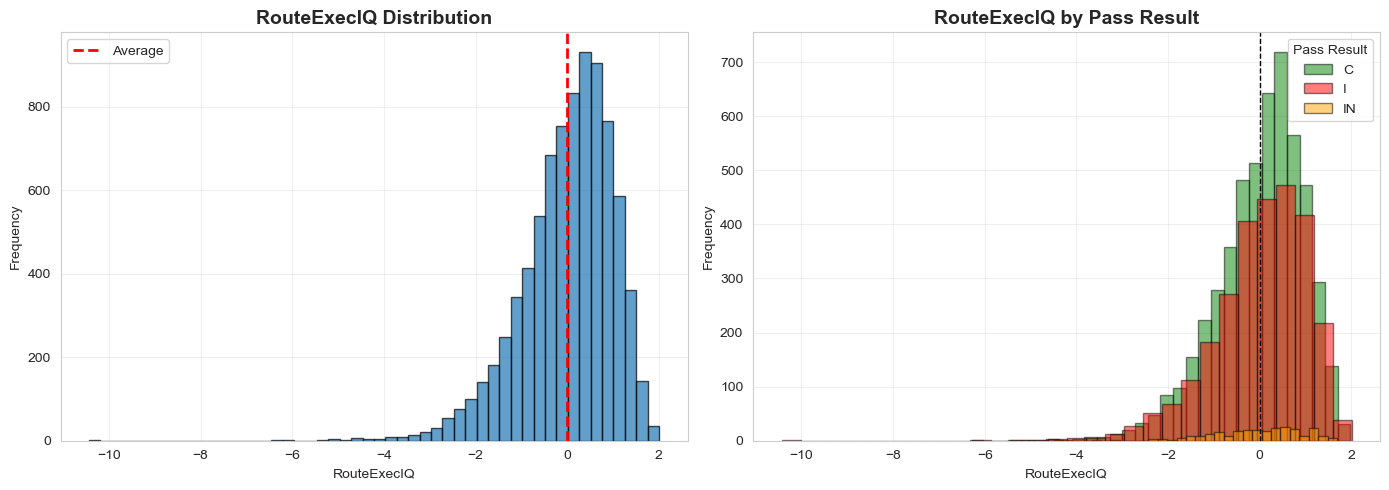


RouteExecIQ by pass result:
                 mean       std  count
pass_result                           
C            0.006267  0.975873   5199
I           -0.007912  1.041496   2744
IN          -0.041989  1.010772    259


In [115]:
# Visualize RouteExecIQ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(df_routes['RouteExecIQ'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Average')
axes[0].set_title('RouteExecIQ Distribution', fontweight='bold', fontsize=14)
axes[0].set_xlabel('RouteExecIQ')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# By pass result
for result, color in [('C', 'green'), ('I', 'red'), ('IN', 'orange')]:
    subset = df_routes[df_routes['pass_result'] == result]['RouteExecIQ']
    axes[1].hist(subset, bins=30, alpha=0.5, label=result, color=color, edgecolor='black')

axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('RouteExecIQ by Pass Result', fontweight='bold', fontsize=14)
axes[1].set_xlabel('RouteExecIQ')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Pass Result')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Stats by pass result
print("\nRouteExecIQ by pass result:")
print(df_routes.groupby('pass_result')['RouteExecIQ'].agg(['mean', 'std', 'count']))

## 3.4 Outputs and Visualizations

Coach-friendly visualizations and explanations of the metrics.

---

In [ ]:
# 1. LOAD DATA
# (Assuming files are loaded as per your paths)
df_preds = pd.read_csv(r'C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\postthrow_predictions_BlindPhysics_Completed_Pass.csv')
df_routes = pd.read_csv(r'C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\RouteExecIQ.csv')
df_sep = pd.read_csv(r'C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\df_postthrow_defender_sep.csv')

# ---------------------------------------------------------
# 2. DATA PREPARATION (Play Level)
# ---------------------------------------------------------
# A. Get TrueSpeed
df_truespeed = df_preds.groupby(['game_id', 'play_id'])['residual'].mean().reset_index()
df_truespeed.rename(columns={'residual': 'TrueSpeed'}, inplace=True)

# B. Get Defender Separation
df_sep_play = df_sep.groupby(['game_id', 'play_id'])['defender_separation'].mean().reset_index()

# C. Merge into Master DataFrame (Play Level)
# Left join ensures we keep all routes to calculate total volume/yards later
df_merged = df_routes.merge(df_truespeed, on=['game_id', 'play_id'], how='left')
df_merged = df_merged.merge(df_sep_play, on=['game_id', 'play_id'], how='left')

# D. Clean Data
if 'player_position' in df_merged.columns:
    df_merged = df_merged[df_merged['player_position'] == 'WR'].copy()

junk_routes = ['SCREEN', 'FLAT', 'ANGLE', 'WHEEL', 'SHIELD']
if 'route_label' in df_merged.columns:
    df_merged = df_merged[~df_merged['route_label'].isin(junk_routes)].copy()

# ---------------------------------------------------------
# 3. HYBRID 3.0 SCORING (Process Metrics)
# ---------------------------------------------------------
# We calculate IQ only for plays where we have speed/separation data (likely completions)
df_scored = df_merged.dropna(subset=['TrueSpeed', 'defender_separation']).copy()
REAL_OPEN_THRESHOLD = 3.0

def calculate_hybrid_airplay_iq(row):
    ts = row['TrueSpeed']
    re = row['RouteExecIQ']
    sep = row['defender_separation']
    
    # Diff Multiplier
    # --- A. Difficulty Multiplier ---
    # Rewards players for winning in tight windows (< 2.0 yards).
    # Logic: 0.5 yds sep = 1.5x Bonus. > 2.0 yds sep = 1.0x (No Bonus).
    sep_diff = min(max(sep, 0.5), 2.0)
    diff_mult = 1.0 + (0.5 * (1.0 - ((sep_diff - 0.5) / 1.5)))
    
    if sep > REAL_OPEN_THRESHOLD:
        # CASE 1: WIDE OPEN (> 3.0 yards)
        # Logic: Ignore Route Style. Score = Speed Residual + Win Bonus.
        # This saves Tyreek Hill/Zay Flowers from their "bad route" penalties.
        return ts + 0.05
    else:
        # CASE 2: CONTESTED / TRAFFIC (<= 3.0 yards)
        # Logic: Technique matters here. Use Weighted Formula.
        # 80% Speed / 20% Route Execution
        return (0.8 * ts * diff_mult) + (0.2 * re)

df_scored['AirPlayIQ_Hybrid'] = df_scored.apply(calculate_hybrid_airplay_iq, axis=1)

# AGGREGATE PROCESS METRICS (Player Level)
player_process = df_scored.groupby('player_name').agg({
    'AirPlayIQ_Hybrid': 'mean',
    'TrueSpeed': 'mean',
    'RouteExecIQ': 'mean',
    'game_id': 'count' # This is "Scored Routes"
}).rename(columns={'game_id': 'Scored_Count'})

# ---------------------------------------------------------
# 4. PRODUCTION METRICS (Context & Outcome)
# ---------------------------------------------------------
# We use the full df_merged (all targets) for production stats
df_merged['is_catch'] = df_merged['pass_result'].apply(lambda x: 1 if x == 'C' else 0)
df_merged['is_explosive'] = df_merged['yards_gained'].apply(lambda x: 1 if x >= 20 else 0)
df_merged['is_successful'] = df_merged['expected_points_added'].apply(lambda x: 1 if x > 0 else 0)

player_production = df_merged.groupby('player_name').agg({
    'game_id': 'count', # Total Targets
    'yards_gained': 'sum',
    'expected_points_added': 'sum',
    'is_catch': 'mean',
    'is_explosive': 'sum',
    'is_successful': 'mean'
}).rename(columns={
    'game_id': 'Total_Targets',
    'yards_gained': 'Total_Yards',
    'expected_points_added': 'Total_EPA',
    'is_catch': 'Catch_Rate',
    'is_explosive': 'Explosive_Plays',
    'is_successful': 'Success_Rate'
})

# Efficiency Rates
player_production['Yards_Per_Target'] = player_production['Total_Yards'] / player_production['Total_Targets']
player_production['EPA_Per_Target'] = player_production['Total_EPA'] / player_production['Total_Targets']

# ---------------------------------------------------------
# 5. MERGE & RANK (Final Step)
# ---------------------------------------------------------
# Combine Process (IQ) + Production (Yards)
df_final = player_process.join(player_production, how='inner')

# Filter for Volume (Starters)
threshold = df_final['Total_Targets'].max() * 0.50
df_qualified = df_final[df_final['Total_Targets'] > threshold].copy()

# Rank
df_qualified['Rank'] = df_qualified['AirPlayIQ_Hybrid'].rank(ascending=False)

# Display
print(df_qualified.sort_values('Rank').head(10))

                  AirPlayIQ_Hybrid  TrueSpeed  RouteExecIQ  Scored_Count  Total_Targets  Total_Yards  Total_EPA  Catch_Rate  Explosive_Plays  Success_Rate  Yards_Per_Target  EPA_Per_Target  Rank
player_name                                                                                                                                                                                       
A.J. Brown                0.065076   0.016077     0.152393           100            137         1416  70.792940    0.729927               20      0.583942         10.335766        0.516737   1.0
Nico Collins              0.062568   0.015905     0.008151            64             85         1156  74.867918    0.752941               24      0.682353         13.600000        0.880799   2.0
Terry McLaurin            0.058420   0.007484     0.110388            65            110          923   8.684534    0.590909               15      0.454545          8.390909        0.078950   3.0
Stefon Diggs             

In [56]:
df_qualified.to_csv(r'C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\Final_Physics_Separation_model_results.csv', index=False)